This notebook does an in depth-analysis of the evolution of the language in the claims section of patents.

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import words
from nltk.metrics.distance import (
    edit_distance,
    jaccard_distance,
    )
from nltk.util import ngrams
nltk.download('words')
import pandas as pd
from PIL import Image
import numpy as np
import pytesseract
from autocorrect import Speller
import neuralcoref
spell = Speller()

[nltk_data] Downloading package words to
[nltk_data]     /Users/andrealphonse/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
import spacy
from spacy import displacy
from collections import Counter
from seg.newline.segmenter import NewLineSegmenter
nlp = spacy.load("en_core_web_lg")
path_to_patents = '/Volumes/Non-Backup_Files/US-patents/random_sample_seeded'

In [4]:
from patent_classification import classify_page, classify_patent, extract_imgs, extract_text, page_has_drawing
from detectron2.data.detection_utils import read_image
from ocrutils import OCR_Pages
import os

In [5]:
claims_df = pd.read_pickle('claims.pkl')
autocorrected_claims_df = pd.read_pickle('autocorrected_claims.pkl')

In [6]:
autocorrected_claims_df.head()

,Date,Claim Text,Claim Length,Reference Count
430,1837,i claim as my invention and desire to secure b...,80,{'i': 1}
1211,1839,i claim as my invention and desire to secure b...,113,{'i': 1}
1645,1840,"i claim as my invention, and desire to secure ...",166,"{'i': 2, 'it': 1}"
1778,1840,i claim there- in as constituting my invention...,162,{'i': 2}
2265,1841,i claim and for which i solicit an exclusive p...,1133,"{'i': 6, 'me': 1, 'it': 9, 'they': 3, 'them': 1}"


In [7]:
example = claims_df['Claim Text'].values[13]
autocorrected_example = autocorrected_claims_df['Claim Text'].values[13]

# I. Erasure of human agency

## A. Lack of references to reader or to oneself

In [8]:
# pronouns "i", 'me', 'my', 'you', 'your', 'we'
#'reader'
# name of inventor
ref_list = ['i', 'me', 'my', 'you', 'your', 'we']
ref_to_reader = 'reader'
def get_refs(text):
    """
    function to count all pronouns as well as references to the reader
    Args:
    text - the text in string form
    Returns:
    refs - a dictionnary of words and their corresponding count
    """
    refs = {}
    doc = nlp(text)
    for token in doc:
        if token.pos_ == 'PRON' or token.text.lower() == 'reader':
            word = token.text.lower()
            if not word in refs.keys():
                refs.update({word: 1})
            else:
                refs.update({word: refs[word]+1})
    return refs


def add_count(row):
    """
    function to add the row with the count of references to the author and to the reader (as well as pronoun counts)
    Args:
    row - the Pandas DataFrame row containing the text column as 'Claim Text'
    Returns:
    row - the row with the column 'Reference Count'
    """
    row['Reference Count'] = get_refs(row['Claim Text'])
    return row

In [ ]:
claims_df = claims_df.apply(add_count, axis=1)
autocorrected_claims_df = autocorrected_claims_df.apply(add_count, axis=1)

In [ ]:
claims_df.head()

In [11]:
claims_df.to_pickle('pickles/claims.pkl')
autocorrected_claims_df.to_pickle('pickles/autocorrected_claims.pkl')

## B. Personnifications

In [6]:
text = 'the knife cuts deep into the cake. pierre disagrees.'
doc = nlp(text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

the DET det
knife NOUN nsubj
cuts VERB ROOT
deep ADV advmod
into ADP prep
the DET det
cake NOUN pobj
. PUNCT punct
pierre PROPN nsubj
disagrees VERB ROOT
. PUNCT punct


## C. Use of agent-less passive form rather than transitive active forms

In [34]:
#NLTK EXPERIMENTS

from nltk import Tree

# parse_str = "(ROOT (S (NP (PRP You)) (VP (MD could) (VP (VB say) (SBAR (IN that) (S (NP (PRP they)) (ADVP (RB regularly)) (VP (VB catch) (NP (NP (DT a) (NN shower)) (, ,) (SBAR (WHNP (WDT which)) (S (VP (VBZ adds) (PP (TO to) (NP (NP (PRP$ their) (NN exhilaration)) (CC and) (NP (FW joie) (FW de) (FW vivre))))))))))))) (. .)))"
#parse_str = "(ROOT (S (SBAR (IN Though) (S (NP (PRP he)) (VP (VBD was) (ADJP (RB very) (JJ rich))))) (, ,) (NP (PRP he)) (VP (VBD was) (ADVP (RB still)) (ADJP (RB very) (JJ unhappy))) (. .)))"
parse_str = 'i am okay'
t = Tree.fromstring(parse_str)
#print t

subtexts = []
for subtree in t.subtrees():
    if subtree.label()=="S" or subtree.label()=="SBAR":
        #print subtree.leaves()
        subtexts.append(' '.join(subtree.leaves()))
#print subtexts

presubtexts = subtexts[:]       # ADDED IN EDIT for leftover check

for i in reversed(range(len(subtexts)-1)):
    subtexts[i] = subtexts[i][0:subtexts[i].index(subtexts[i+1])]

for text in subtexts:
    print(text)

# ADDED IN EDIT - Not sure for generalized cases
leftover = presubtexts[0][presubtexts[0].index(presubtexts[1])+len(presubtexts[1]):]
print(leftover)

ValueError: Tree.read(): expected '(' but got 'i'
            at index 0.
                "i am okay"
                 ^

In [72]:
#experiments
text = 'i claim, and desire to secure by letters patent'
doc = nlp(text)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.i)

i PRON nsubj 0
claim VERB ROOT 1
, PUNCT punct 2
and CCONJ cc 3
desire VERB conj 4
to PART aux 5
secure VERB acl 6
by ADP prep 7
letters NOUN compound 8
patent NOUN pobj 9


In [9]:
def check_neighbors_for_pass(doc,i,nb_neighbors):
    """
    function to check whether there is a auxpass word in the neighbors of a given word
    Args:
    doc - the doc to look in
    i - the index of the central word
    nb_neighbors - the number of neighbors to consider
    Returns:
    a boolean which is True if there is an auxpass word and False otherwise
    """
    if i - nb_neighbors < 0:
        min_ = 0
    else:
        min_ = i-nb_neighbors
    if i + nb_neighbors + 1 >= len(doc):
        max_ = len(doc)
    else:
        max_ = i + nb_neighbors + 1
    for j in range(min_, max_):
        if j != i:
            if doc[j].dep_ == 'auxpass':
                return True
    return False

In [10]:
def get_pass_act_verbs(text, ret_tokens):
    """
    function to get passive and active verb forms from a text
    Args:
    text - the text in string form
    Returns:
    verbs['active'] - a list of the active verbs
    verbs['passive'] - a list of the passive verbs
    len(verbs['active']) - the number of active verbs
    len(verbs['passive']) - the number of passive verbs
    """
    verbs = {'active':[], 'passive':[]}
    doc = nlp(text)
    verb = ''
    for token in doc:
        if token.dep_ == 'auxpass':
            if ret_tokens: 
                verbs['passive'].append(token)
            else:
                verbs['passive'].append(token.text)
        elif (token.pos_ == 'VERB' and token.dep_ == 'ROOT') or token.pos_ == 'AUX' and token.dep_ != 'ROOT':
            index = token.i
            if not check_neighbors_for_pass(doc,index,2):
                if ret_tokens:
                    verbs['active'].append(token)
                else:
                    verbs['active'].append(token.text)
    return verbs['active'], verbs['passive'], len(verbs['active']), len(verbs['passive'])

In [11]:
#some subtle cleaning
def stick_words(row):
    """
    function to remove the '-' that is often put when words break at the end of a line
    Args:
    row - the row of the dataframe containing a 'Claim Text' column
    Returns:
    the row with the clean 'Claim Text' row
    """
    row['Claim Text'] = row['Claim Text'].replace('- ','')
    return row
claims_df = claims_df.apply(stick_words,axis=1)
autocorrected_claims_df = autocorrected_claims_df.apply(stick_words,axis=1)

In [12]:
#getting the passive and active verbs
def add_verb_info(row, ret_tokens=False):
    """
    function to add passive and active verb data to a given row containing a 'Claim Text' column
    Args:
    row - the row containing the 'Claim Text' column
    Returns:
    row - the row with the extra columns active_list (list of active verbs), passive_list (list of passive verbs), nb_active (number of active verbs) and nb_passive (number of passive verbs)
    """
    active_list, passive_list, nb_active, nb_passive = get_pass_act_verbs(row['Claim Text'], ret_tokens)
    row['active_list'] = active_list
    row['passive_list'] = passive_list
    row['nb_active'] = nb_active
    row['nb_passive'] = nb_passive
    return row

In [13]:
claims_df = claims_df.apply(add_verb_info,axis=1)
autocorrected_claims_df = autocorrected_claims_df.apply(add_verb_info,axis=1)

In [14]:
claims_df.head()

,Date,Claim Text,Claim Length,Reference Count,active_list,passive_list,nb_active,nb_passive
430,1837,i claim as my invention and desire to secure b...,80,{'i': 1},"[claim, is, applied, is]",[],4,0
1211,1839,i claim as my invention and desire to secure b...,113,{'i': 1},"[claim, is, described]",[],3,0
1645,1840,"i claim as my invention, and desire to secure ...",166,"{'i': 2, 'it': 1}","[claim, is, constructed, allow]",[being],4,1
1778,1840,"i claim therein as constituting my invention, ...",162,{'i': 2},"[claim, is, claim]",[],3,0
2265,1841,i claim and for which i solicit an exclusive p...,1133,"{'i': 6, 'me': 1, 'it': 9, 'they': 3, 'them': 1}","[claim, be, are, be, represents, consists, is,...","[be, be, is, be, be, be, am, are, is, be, is, ...",17,31


In [24]:
# from seg.newline.segmenter import NewLineSegmenter
# import spacy

# nlseg = NewLineSegmenter()
# nlp = spacy.load('en')
# nlp.add_pipe(nlseg.set_sent_starts, name='sentence_segmenter', before='parser')
# doc = nlp(autocorrected_example)

# II. Erasure of time

## A. Erasure of marks of time or tense

In [139]:
#experiments
text = 'Taken prisoner by the British in December 1776, he was held in New York City for a year '
doc = nlp(text)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.tag_,token.i)

Taken VERB advcl VBN 0
prisoner NOUN dobj NN 1
by ADP agent IN 2
the DET det DT 3
British PROPN pobj NNPS 4
in ADP prep IN 5
December PROPN pobj NNP 6
1776 NUM nummod CD 7
, PUNCT punct , 8
he PRON nsubjpass PRP 9
was AUX auxpass VBD 10
held VERB ROOT VBN 11
in ADP prep IN 12
New PROPN compound NNP 13
York PROPN compound NNP 14
City PROPN pobj NNP 15
for ADP prep IN 16
a DET det DT 17
year NOUN pobj NN 18


In [138]:
#experiments
text = 'being the cpu was a pain in the ass.'
doc = nlp(text)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.tag_,token.i)

being AUX csubj VBG 0
the DET det DT 1
cpu NOUN attr NN 2
was AUX ROOT VBD 3
a DET det DT 4
pain NOUN attr NN 5
in ADP prep IN 6
the DET det DT 7
ass NOUN pobj NN 8
. PUNCT punct . 9


## B. Non-finite verbs vs finite verbs

In [15]:
def get_fin_nonfin_verbs(text, ret_tokens):
    """
    function to get finite and non-finite verbs forms from a text
    Args:
    text - the text in string format
    ret_tokens - whether to returns strings or token objects
    Returns:
    verbs['finite'] - a list of the finite form verbs
    len(verbs['finite']) - the number of finite form verbs in the text
    verbs['non-finite'] - a list of the non-finite form verbs
    len(verbs['non-finite']) - the number of non-finite verbs in the text
    """
    verbs = {'finite':[], 'non-finite':[]}
    doc = nlp(text)
    verb = ''
    for token in doc:
        if token.tag_ == 'VB' or token.tag_ == 'VBD' or token.tag_ == 'VBD' or token.tag_ == 'VBG' or token.tag_ == 'VBN' or token.tag_ == 'VBP' or token.tag_ == 'VBZ':
            if token.tag_ == 'VB':
                if ret_tokens:
                    verbs['non-finite'].append(token)
                else:
                    verbs['non-finite'].append(token.text)
            elif token.tag_ == 'VBG':
                if token.i == 0:
                    if ret_tokens:
                        verbs['non-finite'].append(token)
                    else:
                        verbs['non-finite'].append(token.text)
                elif not (doc[token.i-1].tag_ == 'VBD' or doc[token.i-1].tag_ == 'VBP' or doc[token.i-1].tag_ == 'VBP' or doc[token.i-1].tag_ == 'VBZ'):
                    if ret_tokens:
                        verbs['non-finite'].append(token)
                    else:
                        verbs['non-finite'].append(token.text)
            elif token.tag_ == 'VBN':
                if ret_tokens:
                    verbs['non-finite'].append(token)
                else:
                    verbs['non-finite'].append(token.text)
            else:
                if ret_tokens:
                    verbs['finite'].append(token)
                else:
                    verbs['finite'].append(token.text)
    return verbs['finite'], len(verbs['finite']), verbs['non-finite'], len(verbs['non-finite'])


In [152]:
get_fin_nonfin_verbs(example)

([claim, is, rests, described, allow],
 5,
 [desire,
  secure,
  constructed,
  described,
  being,
  constructed,
  used,
  permit,
  travel,
  extend,
  carrying,
  described],
 12)

In [16]:
def add_fin_non_fin_row(row, ret_tokens=False):
    """
    function to add finite and non-finite verb data to a given row containing a 'Claim Text' column
    Args:
    row - the row containing the 'Claim Text' column
    Returns:
    row - the row with the extra columns finite_list (list of finite verbs), non_finite_list (list of non-finite verbs), finite_len (number of finite verbs) and non_finite_len (number of non-finite verbs)
    """
    finite_list, finite_len, non_finite_list, non_finite_len = get_fin_nonfin_verbs(row['Claim Text'], ret_tokens)
    row['finite_list'] = finite_list
    row['finite_len'] = finite_len
    row['non_finite_list'] = non_finite_list
    row['non_finite_len'] = non_finite_len
    return row

In [17]:
claims_df = claims_df.apply(add_fin_non_fin_row,axis=1)
autocorrected_claims_df = autocorrected_claims_df.apply(add_fin_non_fin_row,axis=1)

In [18]:
claims_df.head()

,Date,Claim Text,Claim Length,Reference Count,active_list,passive_list,nb_active,nb_passive,finite_list,finite_len,non_finite_list,non_finite_len
430,1837,i claim as my invention and desire to secure b...,80,{'i': 1},"[claim, is, applied, is]",[],4,0,"[claim, is, applied, means, is]",5,"[secure, secured]",2
1211,1839,i claim as my invention and desire to secure b...,113,{'i': 1},"[claim, is, described]",[],3,0,"[claim, is, described]",3,"[secure, described, combined, described]",4
1645,1840,"i claim as my invention, and desire to secure ...",166,"{'i': 2, 'it': 1}","[claim, is, constructed, allow]",[being],4,1,"[claim, is, rests, described, allow]",5,"[desire, secure, constructed, described, being...",12
1778,1840,"i claim therein as constituting my invention, ...",162,{'i': 2},"[claim, is, claim]",[],3,0,"[claim, is, claim, said, set]",5,"[constituting, desire, secure, descend, combin...",10
2265,1841,i claim and for which i solicit an exclusive p...,1133,"{'i': 6, 'me': 1, 'it': 9, 'they': 3, 'them': 1}","[claim, be, are, be, represents, consists, is,...","[be, be, is, be, be, be, am, are, is, be, is, ...",17,31,"[claim, solicit, are, are, applied, is, am, ar...",41,"[be, secured, be, confined, be, formed, intend...",101


# III. Erasure of exophoric references

## A. Avoiding metaphors

## B. Use metaphors as adjectives

## C. Avoid impressionist adjectives

# IV. Analyzing the results

In [19]:
claims_df.groupby('Date').agg('mean')['Claim Length']

Date
1805    1097.000000
1823      79.000000
1835     313.000000
1836     305.666667
1837      80.000000
           ...     
1898     900.838095
1899     802.569767
1900     941.082645
1901     829.750000
1961     123.000000
Name: Claim Length, Length: 65, dtype: float64

there is a date that is obviously incorrect (1961). we will correct it manually.

In [20]:
claims_df['Date'][32641] = 1861
autocorrected_claims_df['Date'][32641] = 1861

/Users/andrealphonse/anaconda/envs/patentproj/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/andrealphonse/anaconda/envs/patentproj/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
claims_df.head()

,Date,Claim Text,Claim Length,Reference Count,active_list,passive_list,nb_active,nb_passive,finite_list,finite_len,non_finite_list,non_finite_len
430,1837,i claim as my invention and desire to secure b...,80,{'i': 1},"[claim, is, applied, is]",[],4,0,"[claim, is, applied, means, is]",5,"[secure, secured]",2
1211,1839,i claim as my invention and desire to secure b...,113,{'i': 1},"[claim, is, described]",[],3,0,"[claim, is, described]",3,"[secure, described, combined, described]",4
1645,1840,"i claim as my invention, and desire to secure ...",166,"{'i': 2, 'it': 1}","[claim, is, constructed, allow]",[being],4,1,"[claim, is, rests, described, allow]",5,"[desire, secure, constructed, described, being...",12
1778,1840,"i claim therein as constituting my invention, ...",162,{'i': 2},"[claim, is, claim]",[],3,0,"[claim, is, claim, said, set]",5,"[constituting, desire, secure, descend, combin...",10
2265,1841,i claim and for which i solicit an exclusive p...,1133,"{'i': 6, 'me': 1, 'it': 9, 'they': 3, 'them': 1}","[claim, be, are, be, represents, consists, is,...","[be, be, is, be, be, be, am, are, is, be, is, ...",17,31,"[claim, solicit, are, are, applied, is, am, ar...",41,"[be, secured, be, confined, be, formed, intend...",101


In [22]:
#pronoun count flattening
ref_list = ['i', 'me', 'my', 'you', 'your', 'we', 'reader']
def add_pronoun_columns(row):
    """
    function to add the number of each reference to the reader or the author
    Args:
    row - thr row with the column 'Reference Count'
    Returns:
    row - the same row with the following columns - Number of i, Number of me, Number of my, Number of you, Number of your, Number of we, Number of reader
    """
    ref_count = row['Reference Count']
    for noun in ref_list:
        if noun in ref_count.keys():
            row['Number of {}'.format(noun)] = ref_count[noun]
        else:
            row['Number of {}'.format(noun)] = 0
    return row

In [23]:
claims_df = claims_df.apply(add_pronoun_columns,axis=1)
autocorrected_claims_df = autocorrected_claims_df.apply(add_pronoun_columns,axis=1)

In [24]:
claims_df.to_pickle('pickles/claims_add.pkl')
autocorrected_claims_df.to_pickle('pickles/autocorrected_claims_add.pkl')

In [25]:
claims_df.columns

Index(['Date', 'Claim Text', 'Claim Length', 'Reference Count', 'active_list',
       'passive_list', 'nb_active', 'nb_passive', 'finite_list', 'finite_len',
       'non_finite_list', 'non_finite_len', 'Number of i', 'Number of me',
       'Number of my', 'Number of you', 'Number of your', 'Number of we',
       'Number of reader'],
      dtype='object')

In [26]:
grouped_claims = claims_df.groupby('Date').agg('mean')
grouped_autocorrected_claims = autocorrected_claims_df.groupby('Date').agg('mean')

In [27]:
grouped_claims.columns

Index(['Claim Length', 'nb_active', 'nb_passive', 'finite_len',
       'non_finite_len', 'Number of i', 'Number of me', 'Number of my',
       'Number of you', 'Number of your', 'Number of we', 'Number of reader'],
      dtype='object')

In [28]:
grouped_claims.head()

,Claim Length,nb_active,nb_passive,finite_len,non_finite_len,Number of i,Number of me,Number of my,Number of you,Number of your,Number of we,Number of reader
Date,,,,,,,,,,,,
1805,1097.000000,19.000000,19.0,47.0,97.000000,0.000000,0.0,0.0,0.0,0.0,3.0,0.0
1823,79.000000,3.000000,0.0,4.0,5.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0
1835,313.000000,9.000000,0.0,13.0,21.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
1836,305.666667,4.666667,2.0,7.0,27.666667,2.333333,0.0,0.0,0.0,0.0,0.0,0.0
1837,80.000000,4.000000,0.0,5.0,2.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:title={'center':'Average Claims Length Throughout The Years'}, xlabel='Date', ylabel='Average Claim Length (in words)'>

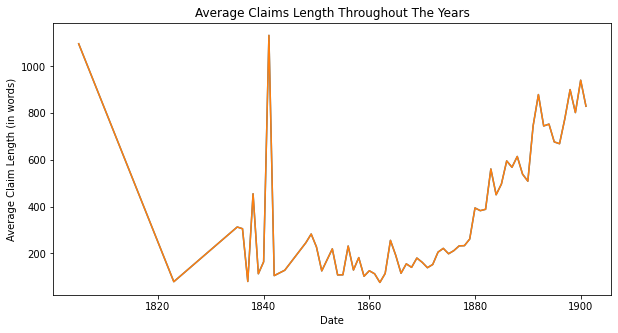

In [29]:
avrg_length = grouped_claims['Claim Length']
avrg_length.plot()
avrg_length.plot(figsize=(10,5),title='Average Claims Length Throughout The Years', ylabel='Average Claim Length (in words)')

<AxesSubplot:title={'center':'Average Claims Length Throughout The Years For Autocorrected Claims'}, xlabel='Date', ylabel='Average Claim Length (in words)'>

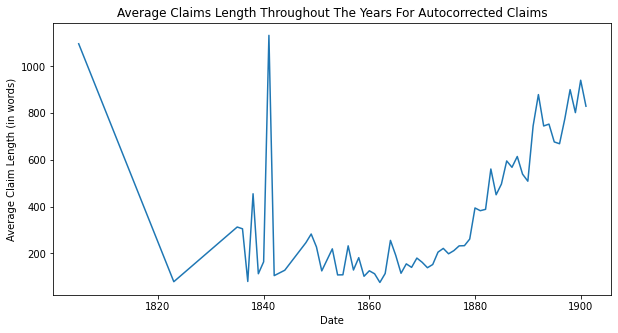

In [30]:
ac_avrg_length = grouped_autocorrected_claims['Claim Length']
ac_avrg_length.plot(figsize=(10,5),title='Average Claims Length Throughout The Years For Autocorrected Claims', ylabel='Average Claim Length (in words)')


In [31]:
#plotting absolute averages
for column in grouped_claims.columns:
    if column != 'Claim Length':
        grouped_claims['{}_per_length'.format(column)] = grouped_claims[column]/grouped_claims['Claim Length']
        grouped_autocorrected_claims['{}_per_length'.format(column)] = grouped_autocorrected_claims[column]/grouped_autocorrected_claims['Claim Length']        
        

In [32]:
grouped_claims.head()

,Claim Length,nb_active,nb_passive,finite_len,non_finite_len,Number of i,Number of me,Number of my,Number of you,Number of your,...,nb_passive_per_length,finite_len_per_length,non_finite_len_per_length,Number of i_per_length,Number of me_per_length,Number of my_per_length,Number of you_per_length,Number of your_per_length,Number of we_per_length,Number of reader_per_length
Date,,,,,,,,,,,,,,,,,,,,,
1805,1097.000000,19.000000,19.0,47.0,97.000000,0.000000,0.0,0.0,0.0,0.0,...,0.017320,0.042844,0.088423,0.000000,0.0,0.0,0.0,0.0,0.002735,0.0
1823,79.000000,3.000000,0.0,4.0,5.000000,2.000000,0.0,0.0,0.0,0.0,...,0.000000,0.050633,0.063291,0.025316,0.0,0.0,0.0,0.0,0.000000,0.0
1835,313.000000,9.000000,0.0,13.0,21.000000,1.000000,0.0,0.0,0.0,0.0,...,0.000000,0.041534,0.067093,0.003195,0.0,0.0,0.0,0.0,0.000000,0.0
1836,305.666667,4.666667,2.0,7.0,27.666667,2.333333,0.0,0.0,0.0,0.0,...,0.006543,0.022901,0.090513,0.007634,0.0,0.0,0.0,0.0,0.000000,0.0
1837,80.000000,4.000000,0.0,5.0,2.000000,1.000000,0.0,0.0,0.0,0.0,...,0.000000,0.062500,0.025000,0.012500,0.0,0.0,0.0,0.0,0.000000,0.0


In [33]:
grouped_claims.columns

Index(['Claim Length', 'nb_active', 'nb_passive', 'finite_len',
       'non_finite_len', 'Number of i', 'Number of me', 'Number of my',
       'Number of you', 'Number of your', 'Number of we', 'Number of reader',
       'nb_active_per_length', 'nb_passive_per_length',
       'finite_len_per_length', 'non_finite_len_per_length',
       'Number of i_per_length', 'Number of me_per_length',
       'Number of my_per_length', 'Number of you_per_length',
       'Number of your_per_length', 'Number of we_per_length',
       'Number of reader_per_length'],
      dtype='object')

In [34]:
proper_column_names = {'nb_active': 'Number of verbs in active form',
 'nb_passive': 'Number of verbs in passive form', 'finite_len': 'Number of finite verbs',
       'non_finite_len': 'Number of non-finite verbs', 'Number of i': 'Number of \'i\'s', 'Number of me': 'Number of \'me\'s', 'Number of my': 'Number of \'my\'s',
       'Number of you': 'Number of \'you\'s', 'Number of your': 'Number of \'your\'s', 'Number of we': 'Number of \'we\'s', 'Number of reader': 'Number of \'reader\'s',
       'nb_active_per_length': 'Number of verbs in the active form divided by average length in words', 'nb_passive_per_length': 'Number of verbs in the passive form divided by average length in words',
       'finite_len_per_length': 'Number of finite verbs divided by average length in words', 'non_finite_len_per_length' : 'Number of non-finite verbs divided by average length in words',
       'Number of i_per_length': 'Number of \'i\'s divided by average length in words', 'Number of me_per_length': 'Number of \'me\'s divided by average length in words',
       'Number of my_per_length': 'Number of \'my\'s divided by average length in words', 'Number of you_per_length': 'Number of \'you\'s divided by average length in words',
       'Number of your_per_length': 'Number of \'your\'s divided by average length in words', 'Number of we_per_length': 'Number of \'we\'s divided by average length in words',
       'Number of reader_per_length': 'Number of \'reader\'s divided by average length in words'}
grouped_claims = grouped_claims.rename(columns=proper_column_names)
grouped_autocorrected_claims = grouped_autocorrected_claims.rename(columns=proper_column_names)

In [35]:
proper_column_names_lower = {v:v.lower() for k,v in proper_column_names.items()}
grouped_claims = grouped_claims.rename(columns=proper_column_names_lower)
grouped_autocorrected_claims = grouped_autocorrected_claims.rename(columns=proper_column_names_lower)

In [36]:
grouped_claims.to_pickle('pickles/grouped_claims.pkl')
grouped_autocorrected_claims.to_pickle('pickles/grouped_autocorrected_claims.pkl')

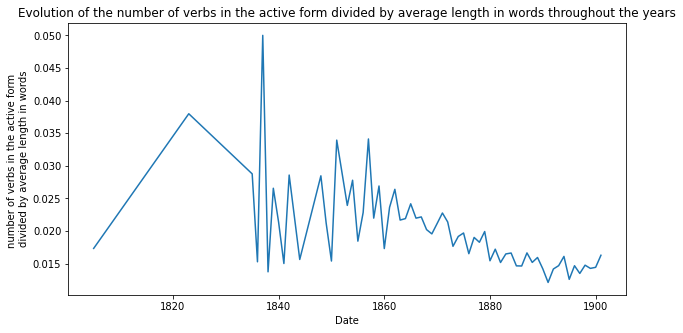

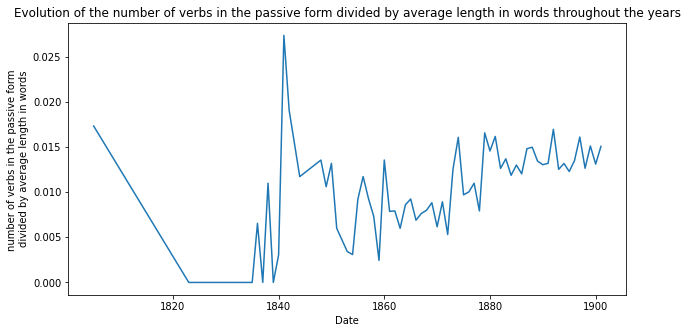

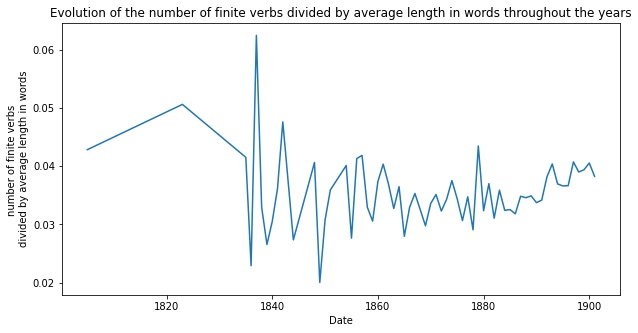

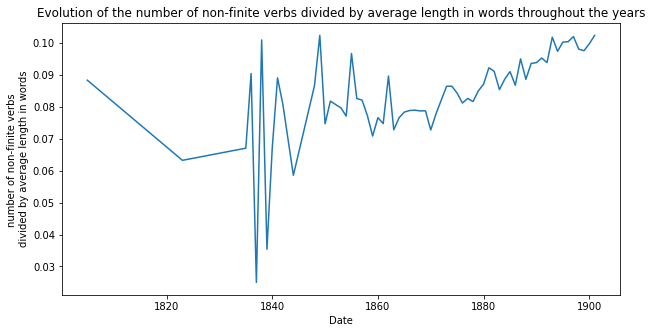

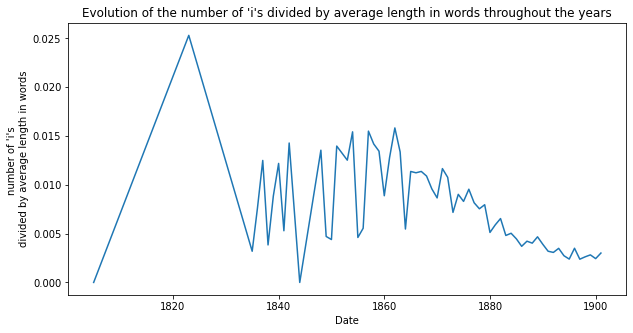

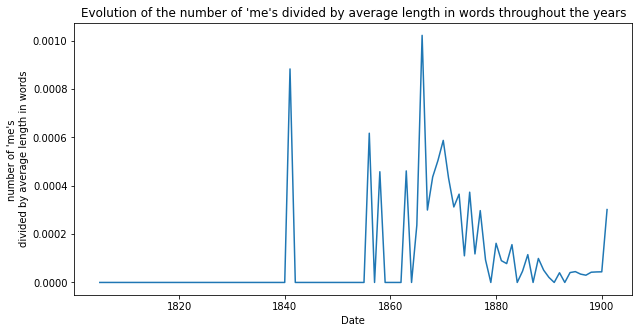

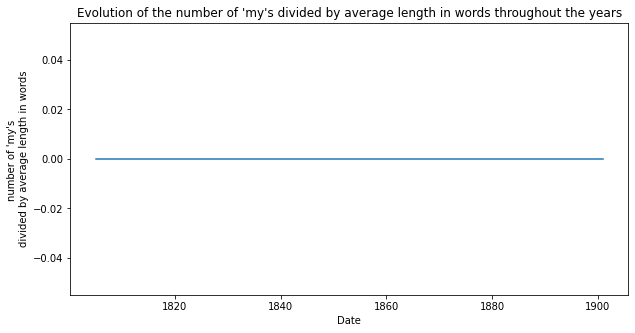

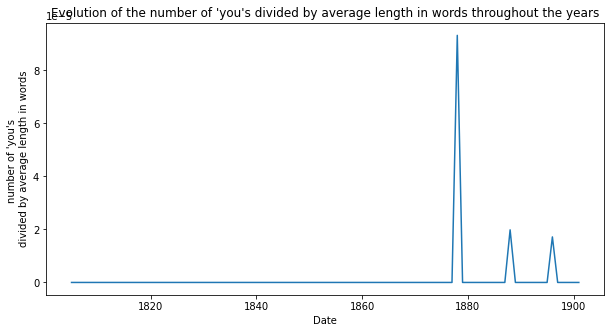

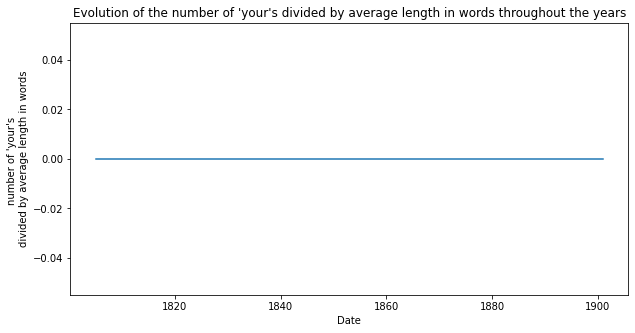

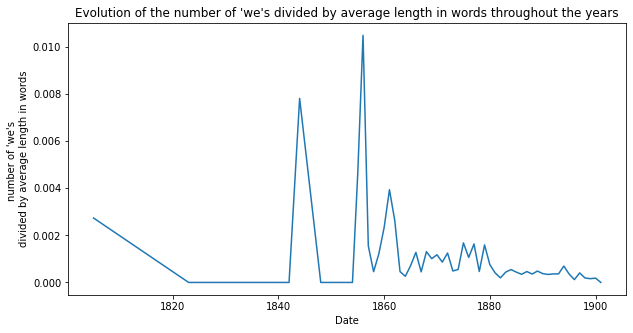

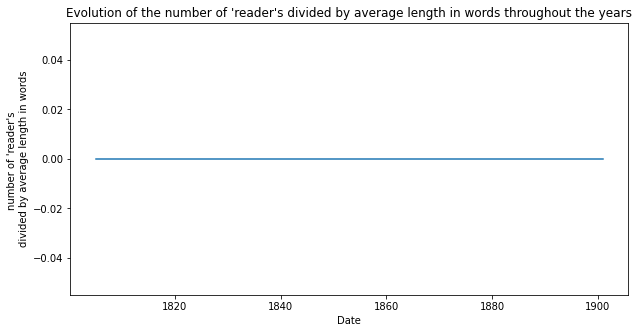

In [70]:
import matplotlib.pyplot as plt
for column in grouped_claims.columns:
    if 'divided by average length in words' in column:
        fig, ax = plt.subplots()
        grouped_claims[column].plot(figsize=(10,5),title='Evolution of the {} throughout the years'.format(column), ylabel='{}{}{}'.format(column[:-34],'\n',column[-34:]))    